In [1]:
import pandas as pd
import numpy as np
import glob
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

In [2]:
def get_meta(path):
    props = os.path.splitext(os.path.basename(path))[0].split('_')
    values = [int(x[1:]) for x in props[1:]]

    return {'max_value':values[0],
            'threads':values[1],
            'input_size_approx':values[2],
            'repeats':values[3]}

In [3]:
def load(file):
    """Load the experiment data from a CSV file with converter metrics."""
        
    schema = {
        'num_threads': np.int64(),
        'num_jsons_converted': np.int64(),
        'num_json_bytes_converted': np.int64(),
        'num_recordbatch_bytes': np.int64(),
        'num_ipc': np.int64(),
        'ipc_bytes': np.int64(),
        'num_buffers_converted': np.int64(),
        't_parse': np.float64(),
        't_resize': np.float64(),
        't_serialize': np.float64(),
        't_thread': np.float64(),
        't_enqueue': np.float64(),
        'status': np.int64()
    }
        
    df = pd.read_csv(file, dtype=schema)
    
    meta = get_meta(file)

    for key, value in meta.items():  
        df.insert(0, key, value)
        
    # Make sure there were no errors for converters.
    assert(df['status'].sum() == len(df.index))
        
    return df

In [4]:
def analyze(df):
    """Analyze the experiment data, deriving various metrics such as throughput."""
    # Calculate time spent within the thread as 'other'.
    df['t_other'] = df['t_thread'] - df[['t_parse', 't_resize', 't_serialize', 't_enqueue']].sum(axis=1)
    
    # Calculate the throughput per thread
    df['Parse throughput (in)'] = df['num_json_bytes_converted'] / df['t_parse']
    df['Parse throughput (out)'] = df['num_recordbatch_bytes'] / df['t_parse']
        
    return df

In [5]:
def summarize(df):
    """Summarize the data from one run into one row with averages."""
    
    assert(len(pd.unique(df['max_value'])==1))
    assert(len(pd.unique(df['threads'])==1))
    assert(len(pd.unique(df['input_size_approx'])==1))
    assert(df['num_threads'].sum()==pd.unique(df['threads'])[0])
    repeats = pd.unique(df['repeats'])[0]
    
    row = {'Max. value': pd.unique(df['max_value'])[0],
           'Input size': pd.unique(df['input_size_approx'])[0],
           'Repeats': pd.unique(df['repeats'])[0],
           'Threads': df['num_threads'].sum(),
           'JSONs': df['num_jsons_converted'].sum() / repeats,
           'Bytes (in)': df['num_json_bytes_converted'].sum() / repeats,
           'RecordBatch bytes': df['num_recordbatch_bytes'].sum() / repeats,
           'IPC messages': df['num_ipc'].sum() / repeats,
           'IPC bytes': df['ipc_bytes'].sum() / repeats,
           'Buffers converted': df['num_buffers_converted'].sum() / repeats,
           # For time, we use the max time of all threads, 
           # since the throughput is determined by the slowest thread in the pool,
           # and they all start operating simultaneously
           'Parse time': df['t_parse'].max(),
           'Resize time': df['t_resize'].max(),
           'Serialize time': df['t_serialize'].max(),
           'Enqueue time': df['t_enqueue'].max(),
           'Other time': df['t_other'].max(),
           'Thread time': df['t_thread'].max(),
           'Parse throughput (in)': df['num_json_bytes_converted'].sum() / df['t_parse'].max(),
           'Parse throughput (out)': df['num_recordbatch_bytes'].sum() / df['t_parse'].max()}
              
    return row;

In [11]:
def get_all_data(data_path, schema, impl):
    path = '{}/{}/latency/threads/metrics/{}/'.format(data_path, schema, impl.lower())
    csv_files = []
    for file in glob.glob("{}*.csv".format(path)):
        csv_files.append(file)
    print("Found {} files in {}".format(len(csv_files), path))

    records = []
    for file in csv_files:
        records.append(summarize(analyze(load(file))))


    df = pd.DataFrame.from_records(records)
    df.sort_values(by=['Threads', 'JSONs'], inplace=True)
    df.insert(0,'Implementation', impl)
    
    # Use only best value
    df = df[df['Max. value'] == 18446744073709551615]
    
    # Print max throughput
    display('{} (in) max: {}'.format(impl, df['Parse throughput (in)'].max() * 1e-9))
    # Print mean throughput of highest throughput per input size
    display('{}      mean: {}'.format(impl, df.groupby(['Implementation', 'Input size']).agg({'Parse throughput (in)': 'max'})['Parse throughput (in)'].mean() * 1e-9))
    
    return df

In [12]:
def get_max_throughput_for_max_size(df):
    df = df[df.JSONs == df.JSONs.max()]
    #df.set_index('Threads', inplace=True)

    result = df[df['Parse throughput (in)'] == df['Parse throughput (in)'].max()]

    return result

In [13]:
import matplotlib.pyplot as plt
from utils import lighten_color

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

colors = ['#4878d0', '#6acc64', '#d65f5f', '#d5bb67', '#dc7ec0', '#8c613c']
markers = ['o', 's', 'd']

In [15]:
d_impls = []

#d_impls.append(get_all_data('../experiments/data-p9-trip', 'trip', 'Arrow'))
#d_impls.append(get_all_data('../experiments/data-p9-trip', 'trip', 'Custom'))
#d_impls.append(get_all_data('../experiments/data-p9-trip', 'trip', 'FPGA'))
d_impls.append(get_all_data('../experiments/data-intel-trip', 'trip', 'Arrow'))
d_impls.append(get_all_data('../experiments/data-intel-trip', 'trip', 'Custom'))
d_impls.append(get_all_data('../experiments/data-intel-trip', 'trip', 'FPGA'))

#d_impls.append(get_all_data('../experiments/data-p9-trip-only-cpu', 'trip', 'Arrow'))
#d_impls.append(get_all_data('../experiments/data-p9-trip-only-cpu', 'trip', 'Custom'))

df = pd.concat(d_impls)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
#dfd = df[df['Implementation'] == 'Custom']
#dfd.sort_values(by='Parse throughput (in)', ascending=False, inplace=True)
#dfd['Parse throughput (in)'] = dfd['Parse throughput (in)'] / 2**20
display(df)

max_tp = df['Parse throughput (in)'].max()

# Get all dimensions for plots
input_sizes = np.sort(pd.unique(df['Input size']))
threads = np.sort(pd.unique(df['Threads']))
impls = pd.unique(df['Implementation'])

print("Input sizes    :", input_sizes)
print("Threads        :", threads)
print("Impls          :", impls)

Found 36 files in ../experiments/data-intel-trip/trip/latency/threads/metrics/arrow/


'Arrow (in) max: 2.106769966984357'

'Arrow      mean: 1.6410045394372303'

Found 36 files in ../experiments/data-intel-trip/trip/latency/threads/metrics/custom/


'Custom (in) max: 7.04191582006234'

'Custom      mean: 5.072297502334238'

Found 4 files in ../experiments/data-intel-trip/trip/latency/threads/metrics/fpga/


'FPGA (in) max: 5.487118451612904'

'FPGA      mean: 5.121279959825303'

,Implementation,Max. value,Input size,Repeats,Threads,JSONs,Bytes (in),RecordBatch bytes,IPC messages,IPC bytes,Buffers converted,Parse time,Resize time,Serialize time,Enqueue time,Other time,Thread time,Parse throughput (in),Parse throughput (out)
3,Arrow,18446744073709551615,16777216,8,1,13356.0,1.677624e+07,5.826458e+06,1.0,0.0,1.0,1.072060,0.000007,0.000010,0.000021,0.000172,1.072270,1.251888e+08,4.347860e+07
20,Arrow,18446744073709551615,134217728,8,1,106854.0,1.342172e+08,4.661492e+07,1.0,0.0,1.0,8.287520,0.000009,0.000018,0.000039,0.000314,8.287900,1.295608e+08,4.499770e+07
8,Arrow,18446744073709551615,1073741824,8,1,854840.0,1.073746e+09,3.729182e+08,4.0,0.0,4.0,66.870500,0.000027,0.000049,0.000086,0.000537,66.871200,1.284567e+08,4.461378e+07
27,Arrow,18446744073709551615,8589934592,8,1,6838720.0,8.589965e+09,2.983346e+09,32.0,0.0,32.0,520.443000,0.000196,0.000336,0.000872,0.006597,520.451000,1.320408e+08,4.585856e+07
33,Arrow,18446744073709551615,16777216,8,4,13355.0,1.677524e+07,5.825515e+06,4.0,0.0,4.0,0.411885,0.000009,0.000011,0.000040,0.092977,0.432224,3.258238e+08,1.131484e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,Custom,18446744073709551615,8589934592,8,32,6839168.0,8.590592e+09,2.983583e+09,1024.0,0.0,1024.0,9.759380,0.000136,0.000437,0.001248,2.537631,11.632400,7.041916e+09,2.445715e+09
0,FPGA,18446744073709551615,16777216,8,1,13360.0,1.678118e+07,1.073753e+10,1.0,0.0,8.0,0.030315,0.000009,0.000010,0.000040,0.000624,0.030998,4.428512e+09,2.833607e+12
2,FPGA,18446744073709551615,134217728,8,1,106858.0,1.342220e+08,1.073830e+10,1.0,0.0,8.0,0.204594,0.000010,0.000012,0.000025,0.000636,0.205277,5.248328e+09,4.198872e+11
1,FPGA,18446744073709551615,1073741824,8,1,854856.0,1.073760e+09,4.295673e+10,4.0,0.0,32.0,1.565500,0.000028,0.000035,0.000145,0.002431,1.568140,5.487118e+09,2.195170e+11


Input sizes    : [  16777216  134217728 1073741824 8589934592]
Threads        : [ 1  4  8 12 16 20 24 28 32]
Impls          : ['Arrow' 'Custom' 'FPGA']


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


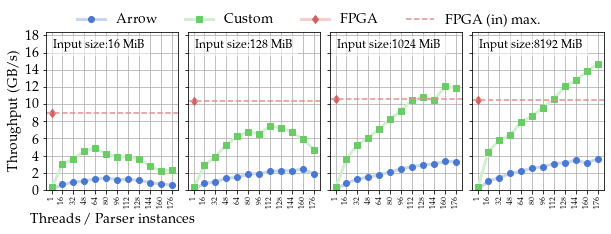

In [10]:
fig, axs = plt.subplots(ncols=len(input_sizes), figsize=[10, 3], sharey=True, sharex=True)

handles = {}

for xa, inps in enumerate(input_sizes):
    ax = axs[xa]

    for i, impl in enumerate(impls):
        # Prepare plotting data
        dl = df[(df['Input size'] == inps) & (df['Implementation'] == impl)]
        y = dl['Parse throughput (in)'] * 1e-9
        y2 = dl['Parse throughput (out)'] * 1e-9
        x = dl['Threads']

        # Plot FPGA data
        handles[impl], = ax.plot(x, y, c=lighten_color(colors[i],0.3), marker=markers[i], mfc=colors[i], mec=colors[i], linewidth=3)

        if impl == 'FPGA':
            handles['FPGA (in) max.'] = ax.axhline(y=y.to_numpy()[-1], color=lighten_color(colors[i],0.7), ls='--')
            # handles['FPGA (out) max.'] = ax.axhline(y=y2.to_numpy()[-1], color=lighten_color(colors[i+1],0.7), ls='--')



    # Set inline 
    ax.annotate("Input size:{:.0f} MiB".format(inps / (1<<20)), 
                xycoords='axes fraction', 
                xy=(0.05, 0.9), 
                fontsize=12,
                backgroundcolor='#FFFFFF80')

    ax.set_xticks(threads)
    ax.set_xticklabels(threads, rotation=90, fontsize=8)

    ax.set_yticks(range(0, 20,2))
    ax.set_ylim(0, 1.25*max_tp * 1e-9)

    ax.grid(which='both')

    if xa == 0:
        ax.set_xlabel('Threads / Parser instances')
        ax.set_ylabel('Throughput (GB/s)')
                        
leg_handles = [v for k,v in handles.items()]
leg_labels = [k for k,v in handles.items()]
fig.legend(leg_handles, leg_labels, ncol=4, bbox_to_anchor=(-0.17, 0.93, 1.0, 0.1), frameon=False)
plt.subplots_adjust(hspace = .1, wspace = .075, bottom=0.15)

fig.savefig("throughput-trip-p9.pdf")